# Desafio Cognitivo.ai

## Imports

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, SGDRegressor, Lasso, ElasticNet
from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor
from sklearn.svm import SVR, LinearSVR
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeRegressor
import lightgbm as lgb
from sklearn.model_selection import GridSearchCV
pd.set_option('display.max_columns',1000)
from feature_engine.encoding import CountFrequencyEncoder
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
import holidays

## Dados

No processo de extração de dados 'listing' fizemos uma pré-seleção das features que possuiam uma quantidade razoável de missings. Por exemplo, excluí as features associadas às review, pois em média, estas possuíam cerca de 10.000 missings. Cheguei a criar um modelos com essas features, mas não obtive um resultado satisfatório que justificasse a utilização das mesmas. Também ajustei a feature 'price' e fiz uma pequena feature engineering na feature 'amenities' para escrevê-la em termos de quantidade de itens ('n_amenities').

In [2]:
# Importing bare data
df_list = pd.read_csv('listings.csv')
cols = ['id','host_since','host_location','host_response_time', 'host_response_rate', 'host_acceptance_rate', 'host_is_superhost', 'host_neighbourhood',
        'host_listings_count','host_total_listings_count',  'host_identity_verified', 'neighbourhood',   'neighbourhood_cleansed', 'latitude','longitude', 'property_type', 'room_type',
        'accommodates', 'bathrooms', 'bathrooms_text', 'bedrooms', 'beds', 'amenities', 'price', 'minimum_nights', 'maximum_nights', 'minimum_minimum_nights','maximum_minimum_nights',
        'minimum_maximum_nights', 'maximum_maximum_nights', 'minimum_nights_avg_ntm', 'maximum_nights_avg_ntm', 'has_availability', 'availability_30', 'availability_60', 'availability_90',
        'availability_365', 'calendar_last_scraped', 'number_of_reviews', 'number_of_reviews_ltm', 'number_of_reviews_l30d', 'first_review', 'last_review', 'review_scores_rating',
        'review_scores_accuracy','review_scores_cleanliness', 'review_scores_checkin', 'review_scores_communication', 'review_scores_location', 'review_scores_value', 'instant_bookable',
        'calculated_host_listings_count','calculated_host_listings_count_entire_homes','calculated_host_listings_count_private_rooms','calculated_host_listings_count_shared_rooms','reviews_per_month']

#column selection

df_list = df_list[cols]

#Data cleaning

df_list['price'] = df_list['price'].apply(lambda x: x.strip('$').replace(',','')).astype(float)
df_list['host_response_rate'] = df_list['host_response_rate'].fillna('0%')
df_list['host_response_rate'] = df_list['host_response_rate'].apply(lambda x: str(x).strip('%')).astype(float)
df_list['host_acceptance_rate'] = df_list['host_acceptance_rate'].apply(lambda x: str(x).strip('%')).astype(float)
df_list['host_since'] = pd.to_datetime(df_list['host_since'])

#dealing with missings and choosing columns to work with

model_cols = ['id',
       'host_response_rate', 'host_is_superhost',
       'host_listings_count','amenities','neighbourhood_cleansed',
       'host_identity_verified', 'latitude', 'longitude',
       'room_type', 'accommodates', 'bedrooms',
       'beds',
       'has_availability',
       'availability_30',
       'availability_365',     
        'instant_bookable',
       'calculated_host_listings_count',
       'calculated_host_listings_count_entire_homes',
       'calculated_host_listings_count_private_rooms']

df_new = df_list[model_cols].copy()


df_new['bedrooms'] = df_new['bedrooms'].fillna(1)
df_new['beds'] = df_new['beds'].fillna(1)


df_new.dropna(subset=['host_is_superhost'],inplace=True)
df_new['n_amenities'] = df_new['amenities'].str.split(',').apply(len)+1
df_new['n_amenities'] = df_new['n_amenities'].astype('int')
df_new.loc[df_new['amenities'] == '{}', 'n_amenities'] = df_new['n_amenities'].mode()
df_new = df_new.drop('amenities', axis=1)
df_new.head()

,id,host_response_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,host_identity_verified,latitude,longitude,room_type,accommodates,bedrooms,beds,has_availability,availability_30,availability_365,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,n_amenities
0,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27
1,25026,89.0,f,11.0,Copacabana,f,-22.97712,-43.19045,Entire home/apt,2,1.0,2.0,t,7,335,f,11,11,0,13
2,35636,100.0,f,1.0,Ipanema,t,-22.98816,-43.19359,Entire home/apt,2,1.0,1.0,t,0,267,f,1,1,0,29
3,35764,100.0,t,1.0,Copacabana,t,-22.98127,-43.19046,Entire home/apt,2,1.0,1.0,t,1,89,f,1,1,0,30
4,41198,80.0,f,4.0,Copacabana,t,-22.97962,-43.19230,Entire home/apt,5,2.0,0.0,t,30,365,f,2,2,0,6


Agora irei importar o 'calendar', que possuí informações com base nas datas. Para melhor trabalharmos com os dados, construí colunas de 'weekday' e 'holiday'.

In [3]:
calendar = pd.read_csv('calendar.csv').drop(['adjusted_price'],axis=1)
calendar['price'] = calendar['price'].apply(lambda x: x.strip('$').replace(',','')).astype(float)
calendar['date'] = pd.to_datetime(calendar['date'])
calendar['weekday'] = calendar['date'].apply(lambda x: x.strftime('%A'))

#Creating holiday column
holidata = pd.DataFrame([])
holidata['date'] = calendar['date'].unique()
holidata['holiday'] = holidata['date'].apply(lambda x: x in holidays.Brazil())
calendar = calendar.merge(holidata,on='date',how='left')
calendar['holiday'] = calendar['holiday'].astype(int)

calendar.drop('date',axis=1,inplace=True)
calendar.drop_duplicates(inplace=True)
calendar.head()

,listing_id,available,price,minimum_nights,maximum_nights,weekday,holiday
0,47173622,f,499.0,1,1125,Thursday,0
1,47173622,t,499.0,1,1125,Friday,1
2,47173622,t,499.0,1,1125,Saturday,0
3,47173622,t,499.0,1,1125,Sunday,0
4,47173622,t,499.0,1,1125,Monday,0


É hora de unificar os dados da 'listings' com 'calendar', conforme segue abaixo:

In [4]:
df_merge = df_new.merge(calendar,left_on='id',right_on='listing_id')
df_merge.head()

,id,host_response_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,host_identity_verified,latitude,longitude,room_type,accommodates,bedrooms,beds,has_availability,availability_30,availability_365,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,n_amenities,listing_id,available,price,minimum_nights,maximum_nights,weekday,holiday
0,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Wednesday,0
1,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Thursday,0
2,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Friday,1
3,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Saturday,0
4,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Sunday,0


## Eliminação de outliers

Dado o volume de dados, iremos simplesmente eliminar as linhas que seja outliers dos dados. Abaixo segue função e implementação da mesma para realizar esse processo:

In [5]:
def get_max_fence(df,column):
    qt = df[column].quantile([0.25,0.75])
    upper = qt.values[1]
    iqr = upper-qt.values[0]
    max_fence = upper + 1.5*(iqr)
    return max_fence

for x in df_merge.columns:
    try:
        df_merge = df_merge[df_merge[x]<=get_max_fence(df_merge,x)].reset_index(drop=True)
    except:
        pass

In [6]:
df_merge.head()

,id,host_response_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,host_identity_verified,latitude,longitude,room_type,accommodates,bedrooms,beds,has_availability,availability_30,availability_365,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,n_amenities,listing_id,available,price,minimum_nights,maximum_nights,weekday,holiday
0,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Wednesday,0
1,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Thursday,0
2,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Friday,1
3,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Saturday,0
4,17878,100.0,t,2.0,Copacabana,t,-22.96592,-43.17896,Entire home/apt,5,2.0,2.0,t,0,0,t,1,1,0,27,17878,f,600.0,5,1125,Sunday,0


In [7]:
df_label_encoder = df_merge.copy()
for column in ('host_is_superhost', 'host_identity_verified', 'has_availability', 'instant_bookable','available'):
    df_label_encoder.loc[df_label_encoder[column] == 'f', column] = 0
    df_label_encoder.loc[df_label_encoder[column] == 't', column] = 1
    df_label_encoder[column] = df_label_encoder[column].astype(int)


fcount = CountFrequencyEncoder(encoding_method='frequency', variables='neighbourhood_cleansed')
df_label_encoder = fcount.fit_transform(df_label_encoder)
df_label_encoder = pd.get_dummies(df_label_encoder)

print('Columns encoded')

Columns encoded


In [8]:
df_label_encoder.drop(['id','listing_id'],axis=1,inplace=True)
df_label_encoder.head()

,host_response_rate,host_is_superhost,host_listings_count,neighbourhood_cleansed,host_identity_verified,latitude,longitude,accommodates,bedrooms,beds,has_availability,availability_30,availability_365,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,n_amenities,available,price,minimum_nights,maximum_nights,holiday,room_type_Entire home/apt,room_type_Hotel room,room_type_Private room,room_type_Shared room,weekday_Friday,weekday_Monday,weekday_Saturday,weekday_Sunday,weekday_Thursday,weekday_Tuesday,weekday_Wednesday
0,100.0,1,2.0,0.336709,1,-22.96592,-43.17896,5,2.0,2.0,1,0,0,1,1,1,0,27,0,600.0,5,1125,0,1,0,0,0,0,0,0,0,0,0,1
1,100.0,1,2.0,0.336709,1,-22.96592,-43.17896,5,2.0,2.0,1,0,0,1,1,1,0,27,0,600.0,5,1125,0,1,0,0,0,0,0,0,0,1,0,0
2,100.0,1,2.0,0.336709,1,-22.96592,-43.17896,5,2.0,2.0,1,0,0,1,1,1,0,27,0,600.0,5,1125,1,1,0,0,0,1,0,0,0,0,0,0
3,100.0,1,2.0,0.336709,1,-22.96592,-43.17896,5,2.0,2.0,1,0,0,1,1,1,0,27,0,600.0,5,1125,0,1,0,0,0,0,0,1,0,0,0,0
4,100.0,1,2.0,0.336709,1,-22.96592,-43.17896,5,2.0,2.0,1,0,0,1,1,1,0,27,0,600.0,5,1125,0,1,0,0,0,0,0,0,1,0,0,0


## Plot da correlação

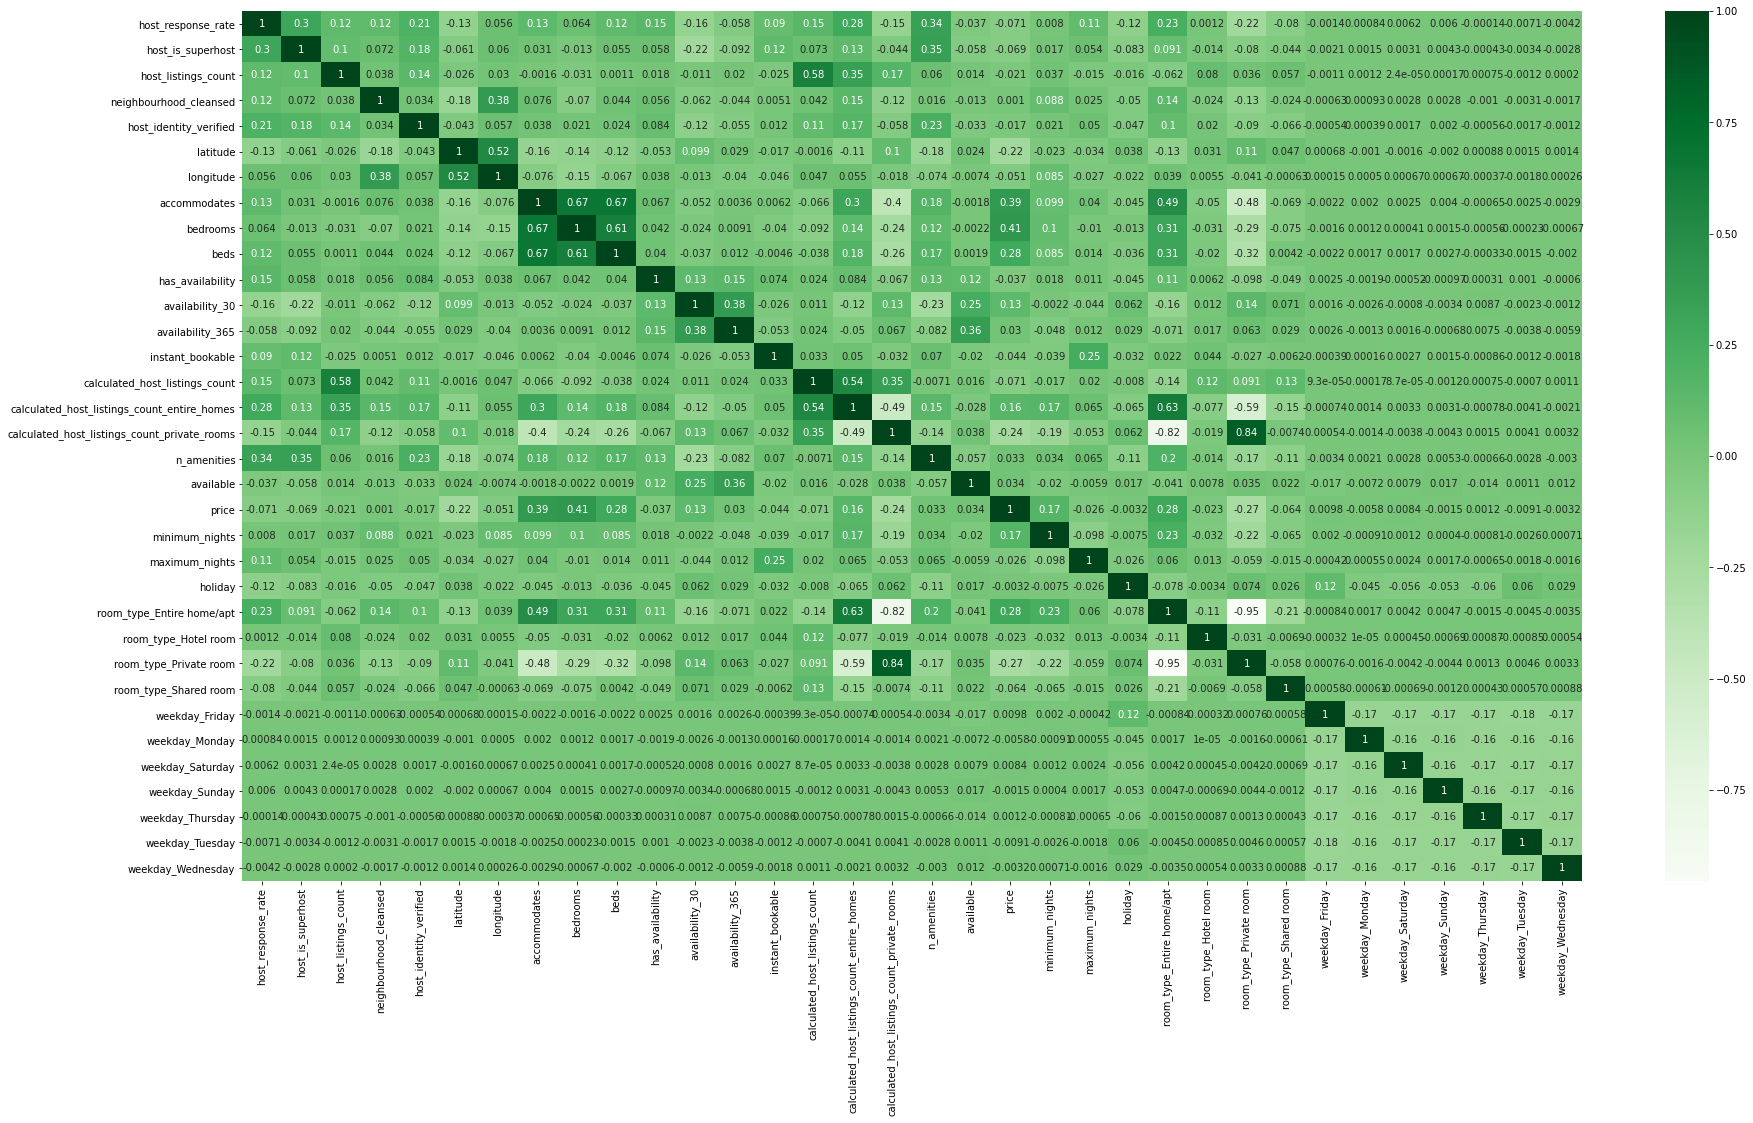

In [9]:
corr = df_label_encoder.corr()
plt.figure(figsize=(30,16))
_ = sns.heatmap(df_label_encoder.corr(), annot=True, cmap='Greens')

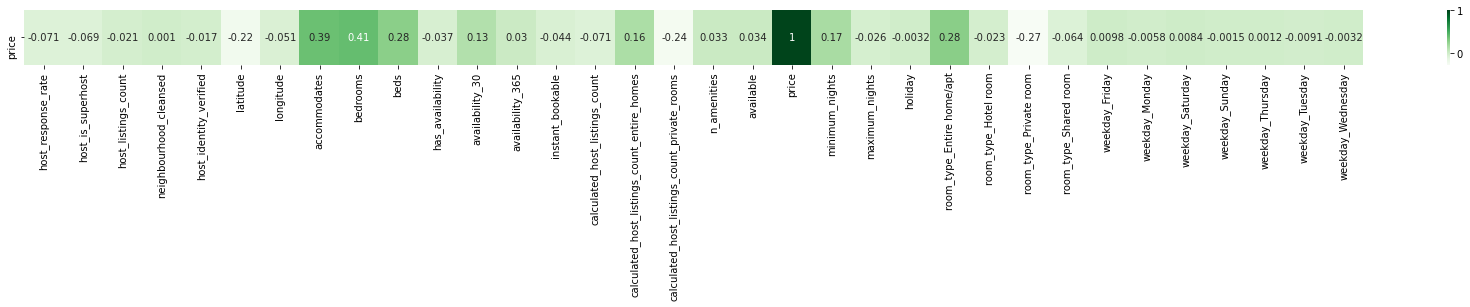

In [10]:
plt.figure(figsize=(30,1))
_ = sns.heatmap(corr.loc[['price'],:], annot=True, cmap='Greens')

Podemos ver que o preço tem a maior correlaçã com o número de quartos, o que faz total sentido, assim com com o room_type, chegando a 0.28 no caso de entire home.

## Modelling

Para modelagem, iremos testar tr

In [11]:
def evaluate(model_name, y_test, predictions):
    RMSE = np.sqrt(mean_squared_error(y_test, predictions))
    MAE = mean_absolute_error(y_test, predictions)
    r2 = r2_score(y_test, predictions)
    return f'model: {model_name}\nMean Absolute Error: {MAE}\nRoot Mean Square Error: {RMSE}\nR² Score: {round(r2*100, 2)}% \n--------------------------------------------'  

In [12]:
y = df_label_encoder['price']
sc = StandardScaler()
X = df_label_encoder.drop('price', axis=1)
sc.fit(X)
X_new = sc.transform(X)

model= lgb.LGBMRegressor(n_estimators=3000,metric='mae')

X_train, X_test, y_train, y_test = train_test_split(X_new,y.values,random_state=1)

model.fit(X_train, y_train)
predictions_test = model.predict(X_test)
predictions_train = model.predict(X_train)
print('Prediction on Test: ',evaluate('LGBM', y_test, predictions_test))
print('Prediction on Train: ',evaluate('LGBM', y_train, predictions_train))

Prediction on Test:  model: LGBM
Mean Absolute Error: 63.673332734628936
Root Mean Square Error: 97.4221409981976
R² Score: 76.95% 
--------------------------------------------
Prediction on Train:  model: LGBM
Mean Absolute Error: 59.84807879888388
Root Mean Square Error: 91.61225086674355
R² Score: 79.62% 
--------------------------------------------


## Cross Validation Score

In [13]:
valid = cross_val_score(estimator=model,X = X_train, y=y_train, cv = 10, scoring='r2')
valid.mean()

0.7689736896933107

Vemos que o cross validation está próximo do resultado sobre a base de teste, o que mostra a qualidade do modelo em termos de overfit. O mesmo trabalha de modo aproximado sobre a base de treino e teste.

## Referêcias

Do seguinte código retirei algumas funções, por exemplo a que remove outliers:

https://www.kaggle.com/allanbruno/helping-regular-people-price-listings-on-airbnb